In [1]:
"""
Author: Somtochukwu Nnajide
Title: Employee Optimisation Genetic Algorithm
Last Modified: 26/10/2024
"""

'\nAuthor: Somtochukwu Nnajide\nTitle: Employee Optimisation Genetic Algorithm\nLast Modified: 26/10/2024\n'

# Libraries


In [2]:
import random
import service_simulator
import operator
import numpy as np
import matplotlib.pyplot as plt

# Genetic Algorithm

In [3]:
class GeneticAlgorithm:
    def __init__(self, population_size, num_generations, mutation_rate, patience, verbose):
        self.population_size = population_size
        self.num_generations = num_generations
        self.mutation_rate = mutation_rate
        self.patience = patience
        self.verbose = verbose

        self.population = []
        self.fitness = []
        self.parents = []
        self.list_of_best_fitness = []

        self.patience_counter = 0
        self.parent_selection = 0
        self.crossover_selection = 0
        self.num_parents = self.population_size // 2
        self.tournament_size = self.population_size // 4
        self.best_fitness = 1000000
        self.best_found_at = -1
        self.best_individual = None

        self.parent_selection_techniques = {
            1:"Elitism",
            2:"Roulette Wheel",
            3:"Tournament Selection",
            4:"Rank Selection"
        }

        self.crossover_selection_techniques = {
            1:"Single-point crossover",
            2:"Two-point crossover",
            3:"Uniform crossover"
        }

        self.menu()
        self.initialisePopulation()

        print("\nFinished initialisation\n")
    
    def menu(self):
        """
        Genetic algorithm menu

        -> Parent technique
        """
        print("Genetic Algorithm Initialisation Menu\n")
        print("Parent selection options (1-4)\n1. Elitism\n2. Roulette Wheel\n3. Tournament selection\n4. Rank Selection\n")
        print("Crossover selection options (1-3)\n1. Singe-point\n2. Two-point\n3. Uniform\n")

        try:
            self.parent_selection = int(input("Parent selection method: "))
            self.crossover_selection = int(input("Crossover method: "))

            print(f"Parent selection method: {self.parent_selection_techniques.get(self.parent_selection)}") 
            print(f"Crossover method: {self.crossover_selection_techniques.get(self.crossover_selection)}")
        except:
            print("No option selected")

    def initialisePopulation(self):
        """
        Chromosome is array of length 50
        Index is department number, i.e, (0-49) -> (1-50)
        Element (gene) is the number of employees assigned to deparment
        Sum of array is always = 80 to match the distributuion of 80 employees

        Appends individuals to population array
        """
        for i in range(self.population_size):
            individual = [1] * 50
            remaining = 80 - sum(individual)

            for _ in range(remaining):
                individual[random.randint(0,49)] += 1

            self.population.append(individual)

    def evaluate(self, generationNumber):
        """
        Evaluate and update the fitness of each solution in a given population
        Fitness array sorted in ascending order -> lowest fitness values kept at top of list along with solution
        """
        #loop through solutions and calculate fitness
        for i in range(len(self.population)):
            fitness = self.calcFitness(self.population[i])
            self.fitness.append((fitness, self.population[i]))

        #sort fitness list by fitness
        self.fitness.sort(key=operator.itemgetter(0)) #sort by ascending

        #update fitness
        if self.fitness[0][0] < self.best_fitness: #lower fitness -> better solution
            self.best_fitness = self.fitness[0][0]
            self.best_individual = self.fitness[0][1]
            self.best_found_at = generationNumber
            self.patience_counter = 0

    def calcFitness(self, individual):
        """"
        Fitness is determined by the weighted formula:
            fitness = 0.8 * average_waiting_time + 0.2 * maximum_waiting_time

        Importance metrics are used as weights
        Objective is to minimise wait time therefore lower fitness is better
        No possible invalid solution therefore fitness value is only returned
        """
        #run simulator to get wait times of given assignment 
        _x, wait_times_per_service = service_simulator.init_and_simulate(individual)
        
        sums = [np.sum(wait_times_per_service[j]) for j in range(len(wait_times_per_service))] #holds the sum of the waiting time for each service
        counts = [len(wait_times_per_service[j]) for j in range(len(wait_times_per_service))] #counts the number of waiting times for each service
        maximums= [np.max(wait_times_per_service[j]) for j in range(len(wait_times_per_service))] #holds maximum waiting time for each service
        
        #mean and max waiting time
        average_waiting_time = np.sum(sums)/np.sum(counts)
        maximum_waiting_time = np.max(maximums)

        fitness = 0.8 * average_waiting_time + 0.2 * maximum_waiting_time

        return fitness
    
    def elitism(self):
        """
        Parent selection via elitism and random selection
        Number of elites -> best quarter of the population
        Number of parents -> Double number of elites

        First portion of parent list are best individuals
        The remainder is randomly selected
        """
        num_elites = self.population_size//4 
        num_parents = num_elites*2

        self.parents = [ft[1] for ft in self.fitness[:num_elites]]  #x elite individuals with best fitness
        other_parents_indices = random.sample(range(num_elites,num_parents), num_parents-num_elites)

        for i in other_parents_indices:
            self.parents.append(self.fitness[i][1]) #selecting the individual

    def roulette_wheel(self):
        """
        Since lower fitness == better -> probability selection is inversely proporional to fitness value
        Invert fitness values so that individuals with lower fitness have higher scores

        For a parent to be selected -> randomly pick a number between 0 and 1 then
        Iterate through the population, sum the probabilities and select the first individual whose
        cumulative probability exceeds the random number
        """
        inverted_fitness = [1/ft[0] for ft in self.fitness]
        total_inverted_fitness = sum(inverted_fitness)
        probabilities = [x/total_inverted_fitness for x in inverted_fitness]

        for _ in range(self.num_parents):
            rand = random.uniform(0, sum(probabilities))
            cumulative_sum = 0

            for i,prob in enumerate(probabilities):
                cumulative_sum += prob

                if rand < cumulative_sum:
                    self.parents.append(self.fitness[i][1])
                    break

    def tournament_selection(self):
        """
        Groups of individuals are randomly selected and the fittest individual from each group
        is selected to be the parent 
        """
        for _ in range(self.num_parents):
            tournament = random.sample(range(len(self.fitness)), self.tournament_size)
            best_individual = min(tournament, key=lambda x: self.fitness[x])
            self.parents.append(self.fitness[best_individual][1])

    def rank_selection(self):
        """
        Individuals are ranked based on fitness and their selection probability is proportional to their
        rank rather than their raw fitness
        -> Reduces the impact of very fit individuals dominating the selection
        """
        #rank based on fitness
        ranked_individuals = sorted(range(len(self.fitness)), key=lambda x: self.fitness[x])

        #assign selection probability based on rank
        total_rank = sum(range(1,len(self.fitness) + 1))
        probabilities = [(i+1)/total_rank for i in range(len(self.fitness))]

        for _ in range(self.num_parents):
            rand = random.uniform(0, sum(probabilities))
            cumulative_sum = 0

            for i, prob in enumerate(probabilities):
                cumulative_sum += prob

                if rand < cumulative_sum:
                    self.parents.append(self.fitness[ranked_individuals[i]][1])
                    break
    
    def selectParents(self):
        match self.parent_selection:
            case 1:
                self.elitism()
            case 2:
                self.roulette_wheel()
            case 3:
                self.tournament_selection()
            case 4:
                self.rank_selection()

    def modifyChild(self, child):
        """
        -> Consideration of edge cases
        -> Sum of children (employees) must equal 80 after crossover
        -> if sum > 80 then decrement
        -> if sum < 80 then increment
        -> else no modification needed 
        """
        max_sum = 80

        if sum(child) > max_sum:
            diff = sum(child) - max_sum

            while diff > 0:
                rand = random.randint(0,49)

                if child[rand] > 1:
                    child[rand] -= 1
                    diff -= 1
        elif sum(child) < max_sum:
            diff = max_sum - sum(child)

            while diff > 0:
                child[random.randint(0,49)] += 1
                diff -= 1
        else:
            return child #unmodified child
        return child #modified child

    def singlePointCrossover(self, parent1, parent2):
        """ 
        -> randomly select single point in parent
        -> divide parent chromosome at selected point
        -> swap parent tails to form new children
        """
        cp = random.randint(0,len(parent1)-1)

        tmp1 = parent1[cp:]
        tmp2 = parent2[cp:]
        child1 = parent1[:cp]
        child2 = parent2[:cp]

        child1.extend(tmp2)
        child2.extend(tmp1)

        child1 = self.modifyChild(child1)
        child2 = self.modifyChild(child2)

        return child1, child2

    def twoPointCrossover(self, parent1, parent2):
        """
        -> cp1 must always be smaller than cp2
        -> cp1 cannot be the largest index in the list
        -> indices must be selected within a valid range to prevent IndexOutOfBounds error
        -> swap segments of arrays to produce offspring
        """
        cp1 = random.randint(0,(len(parent1)-1)-1)
        cp2 = random.randint(cp1+1,len(parent1)-1)

        segment1 = parent1[cp1:cp2+1]
        segment2 = parent2[cp1:cp2+1]

        leftsegment1 = parent1[:cp1]
        leftsegment2 = parent2[:cp1]
        rightsegment1 = parent1[cp2+1:]
        rightsegment2 = parent2[cp2+1:]

        child1 = leftsegment1 + segment2 + rightsegment1
        child2 = leftsegment2 + segment1 + rightsegment2

        child1 = self.modifyChild(child1)
        child2 = self.modifyChild(child2)

        return child1, child2

    def uniformCrossover(self, parent1, parent2):
        """ 
        Each child gene has a 50% chance to be selected from either parent
        """
        child1 = []
        child2 = []

        for i in range(len(parent1)):
            k = random.uniform(0,1)

            if k > 0.5: # select from parent1 first
                child1.append(parent1[i])
                child2.append(parent2[i])
            else:
                child1.append(parent2[i])
                child2.append(parent1[i])

        child1 = self.modifyChild(child1)
        child2 = self.modifyChild(child2)

        return child1, child2

    def crossover(self, parent1, parent2):
        match self.crossover_selection:
            case 1:
                child1, child2 = self.singlePointCrossover(parent1, parent2)
            case 2:
                child1, child2 = self.twoPointCrossover(parent1, parent2)
            case 3:
                child1, child2 = self.uniformCrossover(parent1, parent2)
        
        return child1, child2

    def mutate(self, child):
        """
        Perform swap mutation on genes
        Each child gene has a probability chance to be swapped with another gene
        """
        for _ in range(len(child)):
            k = random.uniform(0,1)

            if k > self.mutation_rate:
                notSwapped = True
                while notSwapped:
                    sp1 = random.randint(0,len(child)-1)
                    sp2 = random.randint(0,len(child)-1)

                    if sp1 != sp2:
                        child[sp1], child[sp2] = child[sp2], child[sp1] # swap
                        notSwapped = False

        return child

    def run(self):
        for g in range(self.num_generations):
            self.evaluate(g)
            self.selectParents()

            new_population = []

            #crossover
            for i in range(self.population_size):
                [parent1Indx ,parent2Indx] = random.sample(range(0,len(self.parents)), 2)
                child1, child2 = self.crossover(self.parents[parent1Indx], self.parents[parent2Indx])
                new_population.append(child1)
                new_population.append(child2)

            #mutate
            for i in range(len(new_population)):
                new_population[i] = self.mutate(new_population[i])

            #track fitness
            self.patience_counter += 1
            self.list_of_best_fitness.append(self.best_fitness)

            if self.patience_counter == self.patience:
                print(f"Stopped after {g} generations\n")
                break
            else:
                if g%10 == 0 and self.verbose:
                    print(f"Generation: {g} Best Fitness so far: {self.best_fitness} Found at generation: {self.best_found_at}")

                self.population = new_population
                self.fitness = []
                self.parents = [] 
        
        print(f"Best individual is: {self.best_individual}\nFitness value is: {self.best_fitness}\nFound at generation: {self.best_found_at}")

# Algorithm params

Genetic Algorithm Initialisation Menu

Parent selection options (1-4)
1. Elitism
2. Roulette Wheel
3. Tournament selection
4. Rank Selection

Crossover selection options (1-3)
1. Singe-point
2. Two-point
3. Uniform

Parent selection method: Tournament Selection
Crossover method: Uniform crossover

Finished initialisation

Stopped after 68 generations

Best individual is: [1, 1, 1, 1, 2, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 2, 1, 2, 1, 1, 1, 1, 1, 1, 3, 2, 3, 1, 1, 1, 1, 1, 2, 7, 1, 2, 2, 1, 1, 2, 3, 1, 1, 1, 2]
Fitness value is: 89.88750081502249
Found at generation: 59


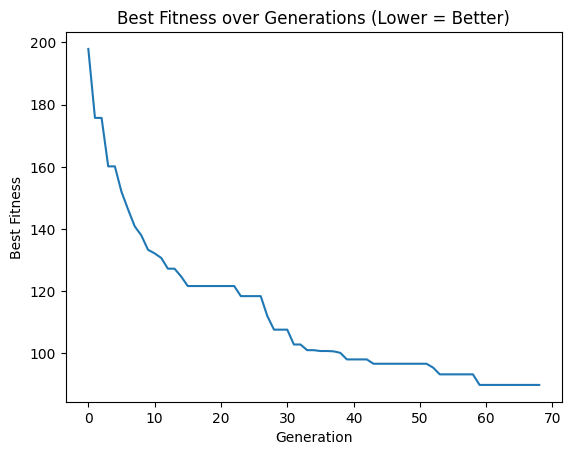

In [9]:
population_size = 500
num_generations = 1000
mutation_rate = 0.9
patience = 10
verbose = False

ga = GeneticAlgorithm(population_size, num_generations, mutation_rate, patience, verbose)

ga.run()

plt.plot(ga.list_of_best_fitness)
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.title("Best Fitness over Generations (Lower = Better)")
plt.show()

# Test performance

In [10]:
run_means = []
run_maxs = []

def testPerformance(run):
    print(f"Run: {run}")

    employee_setting = ga.best_individual

    means = [0 for _ in range(10)]
    maxs = [0 for _ in range(10)]

    for _ in range(10):
        _x, wait_times_per_service = service_simulator.init_and_simulate(employee_setting)
        sums = [np.sum(wait_times_per_service[j]) for j in range(len(wait_times_per_service))]
        counts = [len(wait_times_per_service[j]) for j in range(len(wait_times_per_service))]
        maximums= [np.max(wait_times_per_service[j]) for j in range(len(wait_times_per_service))]
        means[_] =  np.sum(sums)/np.sum(counts)
        maxs[_] = np.max(maximums)

    run_means.append(np.mean(means))
    run_maxs.append(np.mean(maxs))

    print(f"Mean waiting time averaged over 10 simulations: {np.mean(means)}")
    print(f"Max waiting time  averaged over 10 simulations: {np.mean(maxs)}\n")

for i in range(1,11):
    testPerformance(i)

print(f"Average mean wait time over 10 runs: {np.sum(run_means)/10}")
print(f"Average max wait time over 10 runs: {np.sum(run_maxs)/10}\n")



Run: 1
Mean waiting time averaged over 10 simulations: 50.84384468609459
Max waiting time  averaged over 10 simulations: 380.1

Run: 2
Mean waiting time averaged over 10 simulations: 48.955106572184874
Max waiting time  averaged over 10 simulations: 357.1

Run: 3
Mean waiting time averaged over 10 simulations: 50.559592052837004
Max waiting time  averaged over 10 simulations: 365.9

Run: 4
Mean waiting time averaged over 10 simulations: 49.29610627871844
Max waiting time  averaged over 10 simulations: 387.2

Run: 5
Mean waiting time averaged over 10 simulations: 50.41334391916809
Max waiting time  averaged over 10 simulations: 357.7

Run: 6
Mean waiting time averaged over 10 simulations: 50.15931359859545
Max waiting time  averaged over 10 simulations: 372.1

Run: 7
Mean waiting time averaged over 10 simulations: 50.54092645006399
Max waiting time  averaged over 10 simulations: 377.2

Run: 8
Mean waiting time averaged over 10 simulations: 51.20802044438191
Max waiting time  averaged ov